# Controlling MLSVD Truncation 

One of the most important things one need to get right is the truncation of the MLSVD. It doesn't matter how optimized are the CPD routines, it will take a long time to finish the computations if the tensor is big and no compression is made. Many other CPD solvers out there skip the compression stage, and this is one of the reasons (but not the only one) why Tensor Fox is faster. In this lesson we will see some tricks to obtain a decent preprocessed tensor in which we will compute its CPD. Let's work again with the swimmer tensor.

In [1]:
import numpy as np
import matplotlib
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
import TensorFox as tfx

In [2]:
# Load the tensor T, which has shape 256 x 32 x 32. 
T = np.load('swimmer.npy')
m, n, p = T.shape
Tsize = np.linalg.norm(T)

Again, we will consider the rank as $R = 50$. As mentioned in lesson 3, the reduced MLSVD of $T$ is given by $T = (U_1, U_2, U_3) \cdot S$, where $S \in \mathbb{R}^{R_1 \times R_2 \times R_3}$, $U_1 \in \mathbb{R}^{256 \times R_1}$, $U_2 \in \mathbb{R}^{32 \times R_2}$, $U_3 \in \mathbb{R}^{32 \times R_3}$. The tuple $(R_1, R_2, R_3)$ is the multilinear rank of $T$. When the **cpd** function is called, its first action is to run a MLSVD routine and estimate the values $R_1, R_2, R_3$. Since these values are obtained by approximation, based on the energy, the resulting central tensor $S$ is actually a truncation. With less energy we can truncate more, but the default were made so that the truncation is minimal. Below we run the **cpd** with $T$ to remember this.

In [3]:
# Compute the CPD of T, assuming T has rank 50. 
class options:
    display = 3
    
R = 50
factors, T_approx, output = tfx.cpd(T, R, options)

-----------------------------------------------------------------------------------------------
Computing MLSVD
    Compression detected
    Compressing from (256, 32, 32) to (14, 17, 23)
    100.0 % of the energy was retained
    Compression relative error = 1.025811e-14
-----------------------------------------------------------------------------------------------
Type of initialization: random
    Initial guess relative error = 1.434560e+00
-----------------------------------------------------------------------------------------------
Computing CPD
    Iteration | Rel error | Improvement | norm(grad) | Predicted error | # Inner iterations
        1     | 9.70e-01  |  9.70e-01   |  2.47e+03  |    7.60e+03     |        2        
        2     | 1.49e+00  |  5.22e-01   |  3.65e+03  |    1.78e+03     |        3        
        3     | 4.83e-01  |  1.01e+00   |  5.22e+04  |    6.03e+03     |        3        
        4     | 1.65e-01  |  3.18e-01   |  1.27e+04  |    8.26e+02     |        

       87     | 1.87e-03  |  2.40e-04   |  2.64e+00  |    7.96e-03     |        11       
       88     | 1.80e-03  |  7.20e-05   |  8.88e-01  |    5.04e-03     |        25       
       89     | 1.76e-03  |  3.91e-05   |  8.90e-01  |    5.17e-03     |        16       
       90     | 1.73e-03  |  2.71e-05   |  5.42e-01  |    6.01e-03     |        19       
       91     | 1.71e-03  |  2.38e-05   |  5.36e-01  |    4.38e-03     |        19       
       92     | 1.69e-03  |  1.40e-05   |  3.07e-01  |    7.02e-03     |        21       
       93     | 1.67e-03  |  2.63e-05   |  6.46e-01  |    2.15e-02     |        23       
       94     | 1.62e-03  |  4.72e-05   |  9.70e-01  |    8.62e-03     |        25       
       95     | 1.59e-03  |  2.99e-05   |  5.19e-01  |    9.35e-03     |        25       
       96     | 1.56e-03  |  2.87e-05   |  6.90e-01  |    2.31e-03     |        22       
       97     | 1.55e-03  |  1.42e-05   |  4.13e-01  |    2.24e-03     |        15       
       98 

What we know for sure is that $R_1 \leq \min\{ R, m \}$, $R_2 \leq \min\{ R, n \}$, $R_3 \leq \min\{ R, p \}$. This is valid in general for order-$L$ tensors, i.e., $R_\ell \leq \min\{ R, I_\ell \}$ for all $\ell = 1 \ldots L$. What Tensor Fox does it to guess several tuples $(R_1, R_2, R_3)$ and check if the truncation $S[:R_1, :R_2, R_3]$ has energy bigger than the parameter *energy*. Since these tuples are generated from smallest to biggest, the first ocurrence is the one used. In the case no tuple satisfies the condition, the program relies on the safe truncation $(\min\{ R, m \}, \min\{ R, n \}, \min\{ R, p \})$. In fact, this truncation is the default in other solvers, but by doing that we can ending up using an unnecessary big tensor. For example, in the case of the swimmer tensor this tuple is $(50, 32, 32)$, but we just saw that the tuple $(14, 16, 23)$ is already very good (with error of order $10^{-14}$). This is a case where the "safe" tuple may be far away from the actual multilinear rank.

# Truncation Testing 

In more difficult situations one may be interested in testing a list of several possible truncations and choose one of them. This can be accomplished with the function **test_truncation**. Below we show an example of usage with the swimmer tensor. Remember that the ceil for the multilinear rank in this case is $(32, 32, 50)$. 

**PS:** Notice that the order of the dimensions are different here. The **cpd** function sorts the dimension of $T$ is descending order, so the original tensor with shape $32 \times 32 \times 256$ is transformed to have shape $256 \times 32 \times 32$. The truncation testing doesn't change the dimensions order, so the optimal truncation $(14, 16, 23)$ mentioned before is for the sorted $T$. In this context this optimal tuple now is $(23, 16, 14)$. 

In [4]:
# List random of truncations in ascending order.
N = 30
R1_max, R2_max, R3_max = 32, 32, 50
R1_list = np.random.randint(1, R1_max, size=N)
R1_list = np.sort(R1_list)
R2_list = np.random.randint(1, R2_max, size=N)
R2_list = np.sort(R2_list)
R3_list = np.random.randint(1, R3_max, size=N)
R3_list = np.sort(R3_list)
trunc_list = [[R1_list[i], R2_list[i], R3_list[i]] for i in range(N)]

# Start the tests.
trunc_energy, trunc_error = tfx.cmpr.test_truncation(T, Tsize, trunc_list, compute_error=True, display=False)

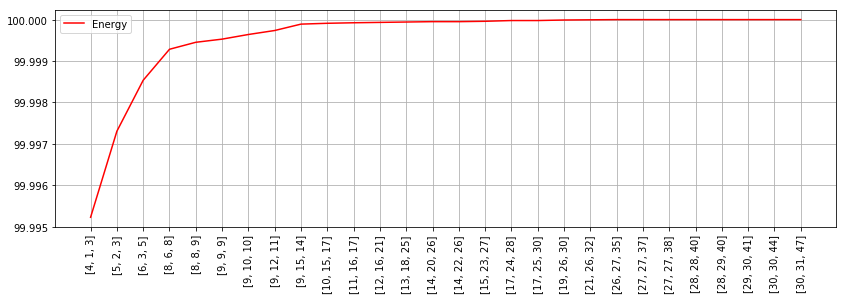

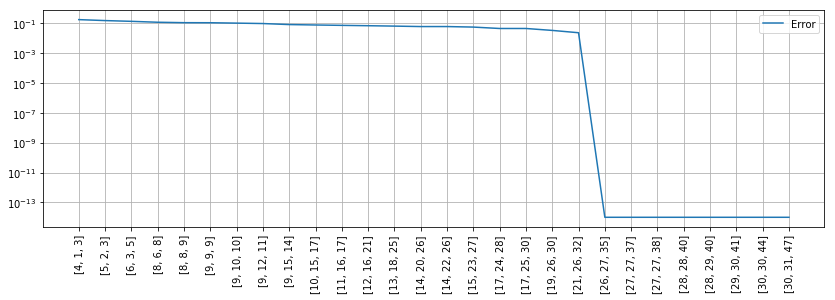

In [5]:
# Now we plot the evolution of the energy and the corresponding errors.
trunc_str = [str(trunc_list[i]) for i in range(N)]

# Energy
plt.figure(figsize=[14, 4])
matplotlib.rc('axes.formatter', useoffset=False)
plt.plot(trunc_str, trunc_energy, color='r', label='Energy')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

# Errors
plt.figure(figsize=[14, 4])
plt.plot(trunc_str, trunc_error, label='Error')
plt.yscale('log')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

It may be not obvious but the reason for the big fall in the error comes from the first dimension, when it changes from $22$ to $23$. Below we make another test to verify this. Also, note that the second dimension doesn't need to be bigger than $21$ and the third dimension doesn't need to be bigger than $42$.

In [6]:
# List random of truncations in ascending order.
N = 30
R2_max, R3_max = 21, 42
R1_list = np.random.randint(22, 24, size=N)
R1_list = np.sort(R1_list)
R2_list = np.random.randint(1, R2_max, size=N)
R2_list = np.sort(R2_list)
R3_list = np.random.randint(1, R3_max, size=N)
R3_list = np.sort(R3_list)
trunc_list = [[R1_list[i], R2_list[i], R3_list[i]] for i in range(N)]

# Start the tests.
trunc_energy, trunc_error = tfx.cmpr.test_truncation(T, Tsize, trunc_list, compute_error=True, display=False)

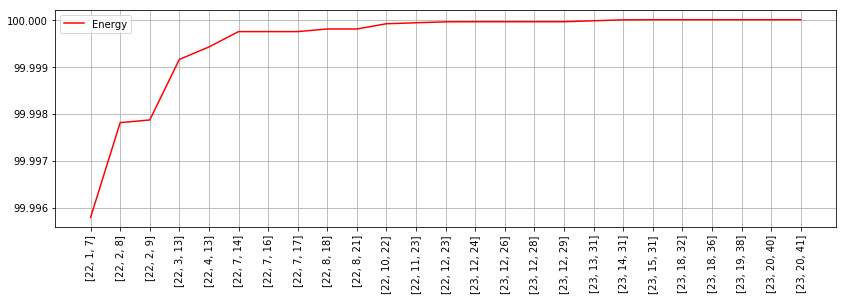

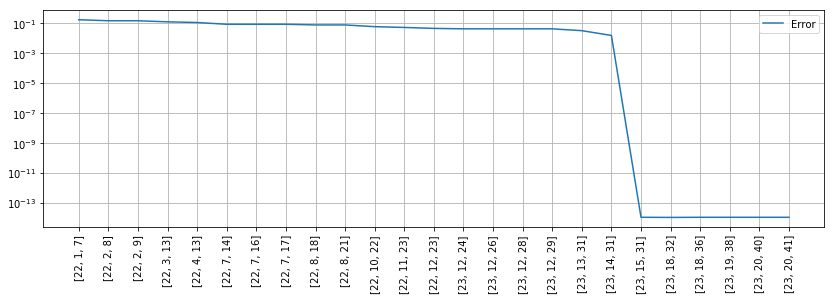

In [7]:
# Now we plot the evolution of the energy and the corresponding errors.
trunc_str = [str(trunc_list[i]) for i in range(N)]

# Energy
plt.figure(figsize=[14, 4])
matplotlib.rc('axes.formatter', useoffset=False)
plt.plot(trunc_str, trunc_energy, color='r', label='Energy')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

# Errors
plt.figure(figsize=[14, 4])
plt.plot(trunc_str, trunc_error, label='Error')
plt.yscale('log')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

# Energy Testing

Although we can try several truncations to look for a good one, sometimes we have no clue about what truncation to test. Another possibility is, we are not interested in testing truncations but in finding the smallest one with more energy than a certain threshold. Maybe it is not the smallest one, but close to the smallest one is good enough. 

We know that the parameter *energy* can be loaded in the **cpd** function. But before that it can be interesting to study how the truncations behave as a function of the energy. Below we show how to do that.

In [8]:
# Compute the SVD of all unfoldings of T.
dims = [m, n, p]
T1 = tfx.cnv.unfold(T, 1, dims)
T2 = tfx.cnv.unfold(T, 2, dims)
T3 = tfx.cnv.unfold(T, 3, dims)
Sigma1, Sigma2, Sigma3, U1, U2, U3 = tfx.cmpr.unfoldings_svd(T1, T2, T3, m, n, p)

# Choose a energy value.
energy = 0.99999

# Compute truncation based on the energy.
stage = 1
S, best_energy, R1, R2, R3, U1, U2, U3, sigma1, sigma2, sigma3, mlsvd_stop, situation = \
            tfx.cmpr.clean_compression(T, T1, T, Sigma1, Sigma2, Sigma3, U1, U2, U3, m, n, p, R, energy, stage)

# Show results.
print('Input energy:', 100*energy)
print('Dimensions of truncation:', R1, R2, R3)
print('Energy of truncation:', best_energy)

Input energy: 99.99900000000001
Dimensions of truncation: 23 16 14
Energy of truncation: 99.99999999999999


In [9]:
# Make the same computations for several possible energies.
for energy in [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999, 0.9999, 0.99999, 0.999999]:
    S, best_energy, R1, R2, R3, U1, U2, U3, sigma1, sigma2, sigma3, mlsvd_stop, situation = \
            tfx.cmpr.clean_compression(T, T1, T, Sigma1, Sigma2, Sigma3, U1, U2, U3, m, n, p, R, energy, stage)
    print('Input energy:', 100*energy)
    print('Dimensions of truncation:', R1, R2, R3)
    print('Energy of truncation:', best_energy)
    print()

Input energy: 40.0
Dimensions of truncation: 2 2 2
Energy of truncation: 98.19490398676875

Input energy: 50.0
Dimensions of truncation: 2 2 2
Energy of truncation: 98.19490398676875

Input energy: 60.0
Dimensions of truncation: 2 2 2
Energy of truncation: 98.19490398676875

Input energy: 70.0
Dimensions of truncation: 2 2 2
Energy of truncation: 98.19490398676875

Input energy: 80.0
Dimensions of truncation: 2 2 2
Energy of truncation: 98.19490398676875

Input energy: 90.0
Dimensions of truncation: 2 2 3
Energy of truncation: 98.23708740025057

Input energy: 95.0
Dimensions of truncation: 2 2 2
Energy of truncation: 98.19490398676875

Input energy: 99.0
Dimensions of truncation: 5 3 10
Energy of truncation: 99.0447370290498

Input energy: 99.9
Dimensions of truncation: 17 15 14
Energy of truncation: 99.93746143039287

Input energy: 99.99
Dimensions of truncation: 22 16 14
Energy of truncation: 99.99156331730362

Input energy: 99.99900000000001
Dimensions of truncation: 23 16 14
Energy